In [123]:
import pandas as pd
import json

import psycopg2
conn = psycopg2.connect(host='ec2-107-20-166-28.compute-1.amazonaws.com',
                        user='rbhciitblovwew',
                        database='db274el0c49tdu')

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(rc={"figure.figsize": (16, 9)})
sns.set(style="whitegrid")

In [128]:
query = """
SELECT
user_id
, (data -> 'activities-heart' ->> 0)::json ->> 'dateTime' as heart_day
, json_array_elements(data -> 'activities-heart-intraday' -> 'dataset') ->> 'value' as bpm
, json_array_elements(data -> 'activities-heart-intraday' -> 'dataset') ->> 'time' as tme
FROM activity_journals
WHERE activity_type = 'heart_rate'
"""
heart_journals = pd.read_sql(query, conn)

In [141]:
query = """
SELECT
user_id
, (data -> 'activities-steps' ->> 0)::json ->> 'dateTime' as step_day
, journal_date
, json_array_elements(data -> 'activities-steps-intraday' -> 'dataset') ->> 'value' as steps
, json_array_elements(data -> 'activities-steps-intraday' -> 'dataset') ->> 'time' as tme
FROM activity_journals
WHERE activity_type = 'steps'
"""
step_journals = pd.read_sql(query, conn)
step_journals.head()

,user_id,step_day,journal_date,steps,tme
0,1,2016-12-11,2016-12-11,0,00:00:00
1,1,2016-12-11,2016-12-11,0,00:01:00
2,1,2016-12-11,2016-12-11,0,00:02:00
3,1,2016-12-11,2016-12-11,0,00:03:00
4,1,2016-12-11,2016-12-11,0,00:04:00


In [160]:
heart_data = heart_journals.copy()
step_data = step_journals.copy()

In [161]:
heart_data['dttm'] = pd.to_datetime(heart_data['heart_day'] + "T" + heart_data['tme'])
heart_data['tme'] = pd.to_datetime(heart_data['tme'])
heart_data['heart_day'] = pd.to_datetime(heart_data['heart_day'])
heart_data['bpm'] = pd.to_numeric(heart_data['bpm'])
# This can probably be done in the database more efficiently
heart_data['seconds_into_the_day'] = (heart_data['dttm'] - heart_data['heart_day']).dt.seconds
#for col in ['heart_day', 'tme']:
#    heart_journals.drop(col, axis=1, inplace=True)
heart_data.set_index('dttm', inplace=True)
heart_data.head()

,user_id,heart_day,bpm,tme,seconds_into_the_day
dttm,,,,,
2016-12-11 00:00:00,1,2016-12-11,55,2016-12-17 00:00:00,0
2016-12-11 00:01:00,1,2016-12-11,56,2016-12-17 00:01:00,60
2016-12-11 00:02:00,1,2016-12-11,55,2016-12-17 00:02:00,120
2016-12-11 00:03:00,1,2016-12-11,55,2016-12-17 00:03:00,180
2016-12-11 00:04:00,1,2016-12-11,55,2016-12-17 00:04:00,240


In [162]:
# copied and pasted from above # TODO: make this a function
step_data['dttm'] = pd.to_datetime(step_data['step_day'] + "T" + step_data['tme'])
step_data['tme'] = pd.to_datetime(step_data['tme'])
step_data['step_day'] = pd.to_datetime(step_data['step_day'])
step_data['steps'] = pd.to_numeric(step_data['steps'])
# This can probably be done in the database more efficiently
step_data['seconds_into_the_day'] = (step_data['dttm'] - step_data['step_day']).dt.seconds

step_data.set_index('dttm', inplace=True)
step_data.head()

,user_id,step_day,journal_date,steps,tme,seconds_into_the_day
dttm,,,,,,
2016-12-11 00:00:00,1,2016-12-11,2016-12-11,0,2016-12-17 00:00:00,0
2016-12-11 00:01:00,1,2016-12-11,2016-12-11,0,2016-12-17 00:01:00,60
2016-12-11 00:02:00,1,2016-12-11,2016-12-11,0,2016-12-17 00:02:00,120
2016-12-11 00:03:00,1,2016-12-11,2016-12-11,0,2016-12-17 00:03:00,180
2016-12-11 00:04:00,1,2016-12-11,2016-12-11,0,2016-12-17 00:04:00,240


In [172]:
steps_and_heart = heart_data.join(step_data, how='left', lsuffix='_heart', rsuffix='_steps')
steps_and_heart['heart_to_step_ratio'] = (steps_and_heart['bpm'] / (steps_and_heart['steps'] + 1)) # + 1 to avoid divide by 0 errors
cols = [
    'heart_day',
    'step_day',
    'bpm',
    'steps',
    'seconds_into_the_day_heart',
    'seconds_into_the_day_steps',
    'heart_to_step_ratio',
]
steps_and_heart[cols].tail()

,heart_day,step_day,bpm,steps,seconds_into_the_day_heart,seconds_into_the_day_steps,heart_to_step_ratio
dttm,,,,,,,
2016-12-04 23:55:00,2016-12-04,2016-12-04,45,0,86100,86100,45.0
2016-12-04 23:56:00,2016-12-04,2016-12-04,45,0,86160,86160,45.0
2016-12-04 23:57:00,2016-12-04,2016-12-04,45,0,86220,86220,45.0
2016-12-04 23:58:00,2016-12-04,2016-12-04,46,0,86280,86280,46.0
2016-12-04 23:59:00,2016-12-04,2016-12-04,46,0,86340,86340,46.0


In [173]:
# computes a five minute rollowing mean
steps_and_heart[['bpm', 'steps', 'heart_to_step_ratio']].rolling(5).var()

,bpm,steps,heart_to_step_ratio
dttm,,,
2016-12-11 00:00:00,NaN,NaN,NaN
2016-12-11 00:01:00,NaN,NaN,NaN
2016-12-11 00:02:00,NaN,NaN,NaN
2016-12-11 00:03:00,NaN,NaN,NaN
2016-12-11 00:04:00,0.2,0.000000e+00,0.2
2016-12-11 00:05:00,9.3,0.000000e+00,9.3
2016-12-11 00:06:00,17.0,0.000000e+00,17.0
2016-12-11 00:07:00,17.0,0.000000e+00,17.0
2016-12-11 00:08:00,18.7,0.000000e+00,18.7


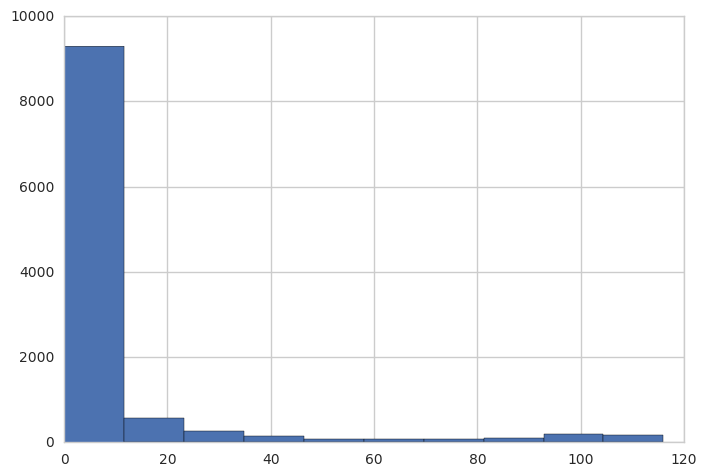

In [177]:
plt.hist(steps_and_heart['steps'])

plt.show()

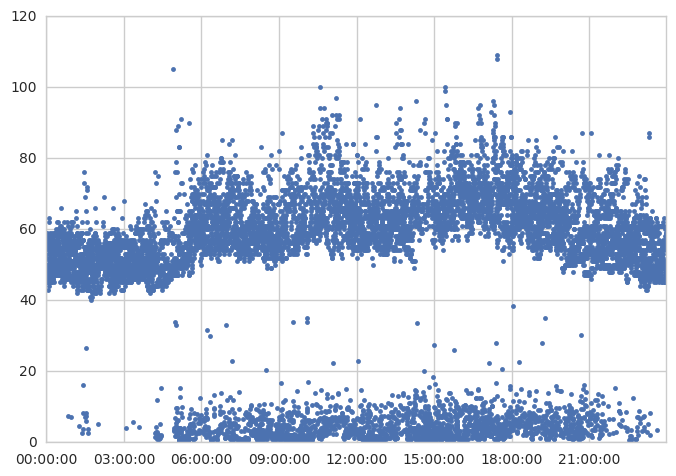

In [180]:
plt.plot(steps_and_heart['tme_steps'], steps_and_heart['heart_to_step_ratio'], '.')

plt.show()

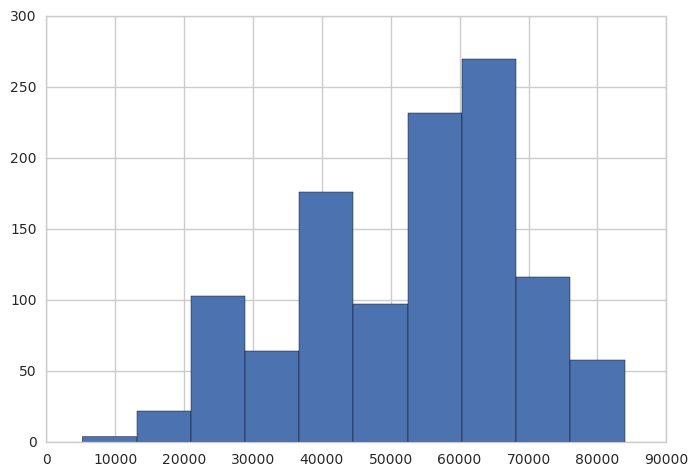

In [189]:
# what do the really high data points mean?

high_ratio = steps_and_heart[ steps_and_heart['heart_to_step_ratio'] >= steps_and_heart['heart_to_step_ratio'].quantile(.9)]
plt.hist(high_ratio['seconds_into_the_day_heart'])

plt.show()

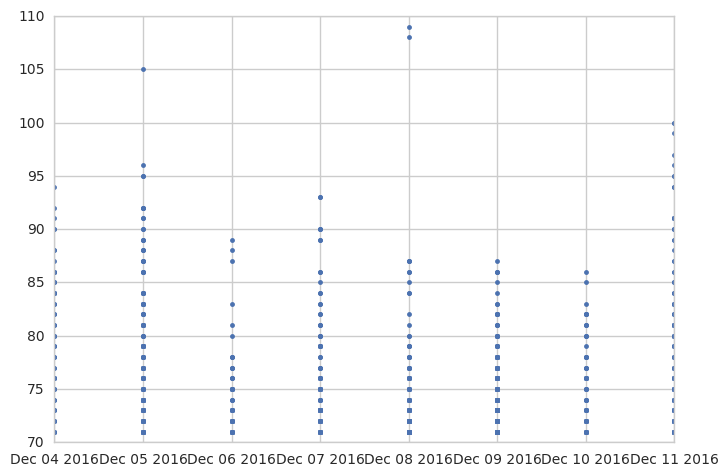

In [193]:
plt.plot(high_ratio['heart_day'], high_ratio['heart_to_step_ratio'], '.')

plt.show()